In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# enable interactive plots
%matplotlib widget

# Import and concatenate all 4D results data into suitable dataframes

In [13]:
import os
import pickle

# Set the directory containing the CSV files
csv_dir = '../results/4d/results'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Concatenate all CSV files into a single dataframe
df_sim = pd.concat([pd.read_csv(os.path.join(csv_dir, f)) for f in csv_files])

# Load pickled train time dataframe
with open('../benchmark-policies/4d/wind_0,9_train_time.pkl', 'rb') as f:
    df_train = pickle.load(f)





# Modify df_train
# Create new columns
df_train['grid_size'] = df_train.index.str.extract(r'^(\d{1,2})\d{1}', expand=False).astype(int)
df_train['obstacle_density'] = df_train.index.str.extract(r'^\d{1,2}(\d{1})', expand=False).astype(int)

# define a dictionary to map the old "density" values to new percentage values
mapping = {1: 0, 2: 0.05, 3: 0.10, 4: 0.15}

# replace the old values with the new values
df_train['obstacle_density'] = df_train['obstacle_density'].replace(mapping)



# Modify df_sim
# Create new columns
df_sim['grid_size'] = df_sim['MDP_ID'].astype(str).str.extract(r'^(\d{1,2})\d{1}', expand=False).astype(int)
df_sim['obstacle_density'] = df_sim['MDP_ID'].astype(str).str.extract(r'^\d{1,2}(\d{1})', expand=False).astype(int)

# define a dictionary to map the old "density" values to new percentage values
mapping = {1: 0, 2: 0.05, 3: 0.10, 4: 0.15}

# replace the old values with the new values
df_sim['obstacle_density'] = df_sim['obstacle_density'].replace(mapping)

In [16]:
df_sim.head()

,dimension,MDP_ID,wind_param,sol_method,l1_norm,no_solutions,solver_time,grid_size,obstacle_density
0,4,131,0.8,IP,0.0,5.0,0.610973,13,0.0
1,4,131,0.8,IP,10.0,13.0,1.634126,13,0.0
2,4,131,0.8,IP,4.0,7.0,0.911011,13,0.0
3,4,131,0.8,IP,2.0,7.0,0.919262,13,0.0
4,4,131,0.8,IP,2.0,7.0,0.931227,13,0.0


In [17]:
df_train.head()

,DP4,MC4,grid_size,obstacle_density
"41_wind_0,9",1.767049,0.336776,4,0.00
"42_wind_0,9",1.755515,0.339481,4,0.05
"43_wind_0,9",1.678167,0.310009,4,0.10
"44_wind_0,9",1.589444,0.298224,4,0.15
"51_wind_0,9",4.588190,0.717241,5,0.00


# Plot stuff

## RL

### Training time trends

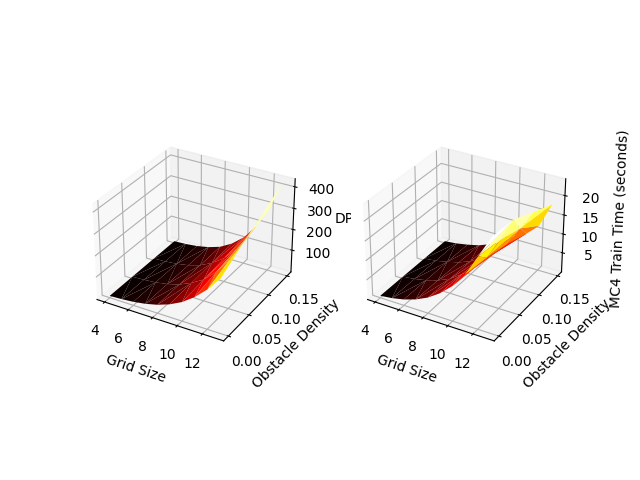

In [7]:
fig = plt.figure()

# First subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(df_train['grid_size'], df_train['obstacle_density'], df_train['DP4'], cmap='hot')
ax1.set_xlabel('Grid Size')
ax1.set_ylabel('Obstacle Density')
ax1.set_zlabel('DP4')


# Second subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(df_train['grid_size'], df_train['obstacle_density'], df_train['MC4'], cmap='hot')
ax2.set_xlabel('Grid Size')
ax2.set_ylabel('Obstacle Density')
ax2.set_zlabel('MC4 Train Time (seconds)')


plt.show()

It's clear that, although the training time trend with respect to grid size is similar, that with respect to obstacle density is not.
Although more obstacles implies more time in computing stuff (whether that's state space backups in DP or experienced simulations in MC), another factor affects the time in MC — the length of simulations. More obstacles --> more crashes --> shorter simulations --> less time to simulate.

### RL Performance trends

In [21]:
df_sim[df_sim['sol_method'].isin(['DP', 'MC'])].head()

,dimension,MDP_ID,wind_param,sol_method,l1_norm,no_solutions,solver_time,grid_size,obstacle_density
300,4,131,0.8,MC,3.0,NaN,NaN,13,0.0
301,4,131,0.8,MC,0.0,NaN,NaN,13,0.0
302,4,131,0.8,MC,3.0,NaN,NaN,13,0.0
303,4,131,0.8,MC,2.0,NaN,NaN,13,0.0
304,4,131,0.8,MC,3.0,NaN,NaN,13,0.0


/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_2152/647048398.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_2152/647048398.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()


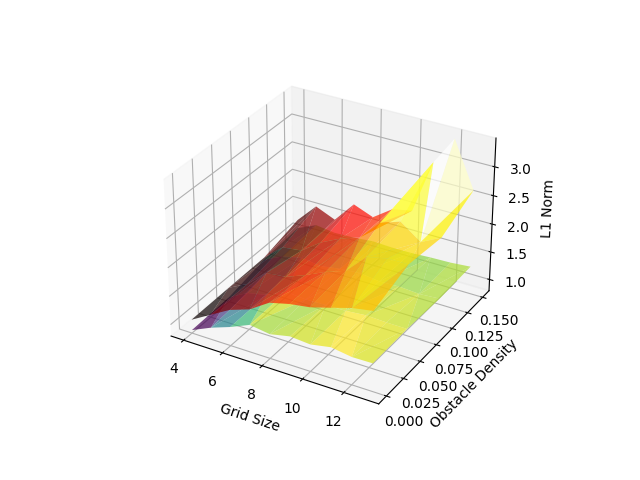

In [112]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

df_sim_mc = df_sim[df_sim['sol_method'] == 'MC']
data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
df_sim_dp = df_sim[df_sim['sol_method'] == 'DP']
data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()

wind_param_vals = [0.8]

for wp in wind_param_vals:
    norm_data_mc = data_mc.loc[:, :, wp]['l1_norm']
    norm_data_dp = data_dp.loc[:, :, wp]['l1_norm']

    # Get the x, y, z values
    x = norm_data_mc.index.get_level_values('grid_size')
    y = norm_data_mc.index.get_level_values('obstacle_density')
    z_mc = norm_data_mc.values
    z_dp = norm_data_dp.values

    # Plot the 3D surfaces
    ax.plot_trisurf(x, y, z_mc, cmap='hot', alpha = 0.7)
    ax.plot_trisurf(x, y, z_dp, cmap='viridis', alpha = 0.7)

# Set labels for the axes
ax.set_xlabel('Grid Size')
ax.set_ylabel('Obstacle Density')
ax.set_zlabel('L1 Norm')

plt.show()


## Integer programming trends